# Basic Go Rules Implementation

---

Created by Willem Hendriks, whendrik@gmail.com

importing libraries

In [1]:
import numpy as np
import os
import tensorflow

from tensorflow.keras.models import load_model

## List all available models

In [2]:
for filename in os.listdir(".."):
    if ".h5" in filename:
        print(filename)

leelazero_10x128.h5
leelazero_1x8.h5
leelazero_6x128.h5
leelazero_15x192.h5
leelazero_4x32.h5
leelazero_5x64.h5


## Basic board situations

To use Leela-Zero, a board situation has to be encoded to a 18 planes encoding. The Keras implementation is in channel-last format, making a 19x19 board, a (19,19,18) vector.

A function do to this for a given `.sgf` file is still on the todo list.

In [3]:
def empty_board():
    empty_board = np.zeros([19,19,18])
    empty_board[:,:,16]  =  empty_board[:,:,16] + 1
    return empty_board

def black_first_move():
    empty_board = np.zeros([19,19,18])
    empty_board[3,3,8] = 1.0
    empty_board[:,:,17]  =  empty_board[:,:,17] + 1
    return empty_board

def switch_player(np_board):
    np_board[:,:,:] = np.transpose(np.transpose(np_board)[np.array([8,9,10,11,12,13,14,15,0,1,2,3,4,5,6,7,17,16])])

## Load a network

In Keras, a `model.summary()` will output the architecture of the model, and a `model.predict()` will score the network on input data, i.e.

```
predictions = model.predict( board_situations )
```

### Output

For `N` board situations, the output is a list of length 2;

1. First element, being a `N x 362` vector, containing 362, logits probabilities for all 361 intersection and the pass move, for `N` board positions.
2. Second element, a `N x 1`, for each board posisiont `N`, a tanh nonlinearity outputting a scalar in range `[-1,1]`, which can be transformed to the probability to win for player to move.

In [4]:
model = load_model("../leelazero_10x128.h5")

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
from dlgo.goboard_fast import Board
from dlgo.gotypes import Player, Point
from dlgo import gotypes

## Go Rules for LeelaZero Numpy encoding

For efficiency, Go rules are applied directly on LeelaZero encoded numpy arrays

---

`has_liberties()` will return `True` when point `(i,j)` has a liberty

In [6]:
def has_liberties(np_board, i,j, my_plane=0, enemy_plane=8):
    return has_liberties_helper( np_board, i,j, checked=[], my_plane=my_plane, enemy_plane=enemy_plane)
    

Helper function for `has_liberties()`

In [7]:
def has_liberties_helper( np_board, i,j, checked=[], my_plane=0, enemy_plane=8 ):
    """
        - We assume the player to move is my_plane, want to check liberties, at point (i,j)
        - Enemy player is on enemy_plane
        - Point (i,j) can be empty, or contain a stone. When already a stone, it is helpful 
        for chechking enemy groups being dead after a stone is placed.

    """
    
    """
        Check, if the point is on the board
    """
    if i > 18 or i < 0 or j > 18 or j < 0: # IS_ON_BOARD
        #print('not-on-board {},{}'.format(i,j))
        return False
    
    """
        If already have checked for liberties, skip this point
    """
    if (i,j) in checked:
        #print("already checked {},{}".format(i,j))
        return False

    """
        If this is a enemy stone, it can't be helpful to check your liberties
    """
    if np_board[i,j,enemy_plane] == 1: # IS_ENEMY_STONE
        return False
    
    """
        Check all neighbors for being empty spots
    """
    if np_board[np.abs(i-1),j,my_plane] == 0 and (np.abs(i-1),j) not in checked and np_board[np.abs(i-1),j,enemy_plane] == 0 :
        #print("found liberty at {},{}, for stone at {},{}".format(np.abs(i-1),j, i,j))
        return True
    if np_board[i,np.abs(18 - abs(17 - j)),my_plane] == 0 and (i,np.abs(18 - abs(17 - j))) not in checked and np_board[i,np.abs(18 - abs(17 - j)),enemy_plane] == 0:
        #print("found liberty at {},{}, for stone at {},{}".format(i,np.abs(18 - abs(17 - j)), i,j))
        return True
    if np_board[i,np.abs(j-1),my_plane] == 0 and (i,np.abs(j-1)) not in checked and np_board[i,np.abs(j-1),enemy_plane] == 0:
        #print("found liberty at {},{}, for stone at {},{}".format(i,np.abs(j-1), i,j))
        return True
    if np_board[np.abs(18 - abs(17 - i)),j,my_plane] == 0 and (np.abs(18 - np.abs(17 - i)),j) not in checked and np_board[np.abs(18 - abs(17 - i)),j,enemy_plane] == 0:
        #print("found liberty at {},{}, for stone at {},{}".format(np.abs(18 - np.abs(17 - i)),j, i,j))
        return True

    """
        Add points to points that are checked for neighbors, but dont have direct liberties
    """
    checked.append( (i,j) )
    
    """
        Expand search for liberties by checking the friendly neigbor stones for liberties.
        
        It is OK if points are checked outside board, of of enemy stones, because those searched get killed 
    """
    # FOR ALL FRIENLY NEIGHBOR STONES
    return has_liberties_helper(np_board, i-1,j, checked, my_plane=my_plane, enemy_plane=enemy_plane) or has_liberties_helper(np_board, i+1,j, checked, my_plane=my_plane, enemy_plane=enemy_plane) or has_liberties_helper(np_board, i,j-1, checked, my_plane=my_plane, enemy_plane=enemy_plane) or has_liberties_helper(np_board, i,j+1, checked, my_plane=my_plane, enemy_plane=enemy_plane)

When a stone is placed, and capture enemy stones, we have to `remove_stones()`

In [8]:
def remove_stones( np_board, i, j, plane):
    LEFT = (np.abs(i-1),j)
    RIGHT = (np.abs(18 - abs(17 - i)),j)
    UP = (i,np.abs(j-1))
    DOWN = (i,np.abs(18 - abs(17 - j)))
    
    if np_board[i,j,plane] == 1:
        np_board[i,j,plane] = 0
        for neighbor in [LEFT,RIGHT,UP,DOWN]:
            k,l = neighbor
            if np_board[k,l,plane] == 1:
                remove_stones( np_board, k, l, plane)
    return True

If a point is not occupied, we can `place_stone()`, if the resulting group `has_liberties()`

In [9]:
def place_stone( np_board, i, j):
    if not np_board[i,j,0] == 0 or not np_board[i,j,8] == 0:
        print( "Already stone at {},{}".format(i,j) )
        return False
    
    PLACED = False
    if has_liberties(np_board, i, j): #HAS_LIBERTIES
        #print("has_liberty")
        np_board[i,j,0] = 1
        PLACED = True
    
    LEFT = (np.abs(i-1),j)
    RIGHT = (np.abs(18 - abs(17 - i)),j)
    UP = (i,np.abs(j-1))
    DOWN = (i,np.abs(18 - abs(17 - j)))

    NEIGHBORS = list(set([LEFT, RIGHT, UP, DOWN]))
    #print(NEIGHBORS)

    for neighbor in NEIGHBORS:
        k, l = neighbor
        #print( "{},{}".format(k,l))
        if np_board[k,l,8] == 1 and not has_liberties_helper(np_board,k,l, checked=[(i,j)], my_plane=8, enemy_plane=0):
            #print("no liberties for {},{} - stone have to be removed".format(k,l))
            remove_stones(np_board,k,l, 8)
            np_board[i,j,0] = 1
            PLACED = True
            
    if not PLACED:
        print( "Couldn't place stone at {},{}".format(i,j) )
        
    return PLACED

## Draw a numpy board


In [10]:
%matplotlib inline

def draw_board(np_board):
    """
    
        Draws a np_board, encoded for Leela-Zero
    
    """
    import matplotlib.pyplot as plt

    # create a 8" x 8" board
    fig = plt.figure(figsize=[8,8])
    fig.patch.set_facecolor((1,1,.8))

    ax = fig.add_subplot(111)

    # draw the grid
    for x in range(19):
        ax.plot([x, x], [0,18], 'k')
    for y in range(19):
        ax.plot([0, 18], [y,y], 'k')

    # scale the axis area to fill the whole figure
    ax.set_position([0,0,1,1])

    # get rid of axes and everything (the figure background will show through)
    ax.set_axis_off()

    # scale the plot area conveniently (the board is in 0,0..18,18)
    ax.set_xlim(-1,19)
    ax.set_ylim(-1,19)

    # draw Go stones at (10,10) and (13,16)

    for row in range(19):
        for col in range(19):
            if np_board[0,0,17] == 1:
                if np_board[row,col,8] == 1:
                    s, = ax.plot(col, 18 - row, 'o',markersize=25, markeredgecolor=(.1,.1,.1), markerfacecolor='k', markeredgewidth=1.4)
                if np_board[row,col,0] == 1:
                    s, = ax.plot(col, 18 - row,'o',markersize=25, markeredgecolor=(0,0,0), markerfacecolor='w', markeredgewidth=1.4)
            else:
                if np_board[row,col,0] == 1:
                    s, = ax.plot(col, 18 - row, 'o',markersize=25, markeredgecolor=(.1,.1,.1), markerfacecolor='k', markeredgewidth=1.4)
                if np_board[row,col,8] == 1:
                    s, = ax.plot(col, 18 - row,'o',markersize=25, markeredgecolor=(0,0,0), markerfacecolor='w', markeredgewidth=1.4)
            
                
    ax.plot()

"""
Lop - none parallel
"""

In [11]:
%%time

board = Board(19,19)
np_board = empty_board()

for _ in range(20):
    preds = model.predict( np.expand_dims(np_board,0))
    
    argmax_move = np.argmax( preds[0][0] )
    move_i = argmax_move // 19
    move_j = argmax_move % 19
    
    player_to_move = Player.black
    
    if np_board[0,0,17] == 1.0:
        player_to_move = Player.white
    

    board.place_stone( player_to_move, Point(move_i +1,move_j+1) )

    np_board[:,:,1] = np_board[:,:,0].copy()
    np_board[move_i,move_j,0] = 1
    np_board[:,:,8] = 0
    

    for row in range(board.num_rows):
        for col in range(board.num_cols):
            stone = board.get(gotypes.Point(row=row+1, col=col+1))
            if stone and stone != player_to_move:
                np_board[row,col,8] = 1

    switch_player(np_board)

CPU times: user 2.46 s, sys: 410 ms, total: 2.87 s
Wall time: 1.83 s


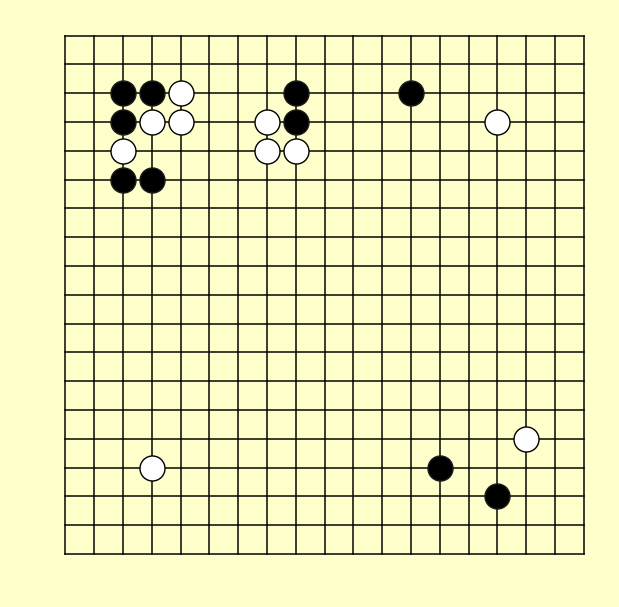

In [12]:
draw_board(np_board)

In [13]:
%%time

np_board = empty_board()

for _ in range(25):
    preds = model.predict( np.expand_dims(np_board,0))
    
    argmax_move = np.argmax( preds[0][0] )
    move_i = argmax_move // 19
    move_j = argmax_move % 19
    
    np_board[:,:,1] = np_board[:,:,0].copy()
    
    while not place_stone(np_board,move_i,move_j):
        preds[0][0][argmax_move] = 0
        argmax_move = np.argmax( preds[0][0] )
        move_i = argmax_move // 19
        move_j = argmax_move % 19
        

    switch_player(np_board)

CPU times: user 2.75 s, sys: 370 ms, total: 3.12 s
Wall time: 1.39 s


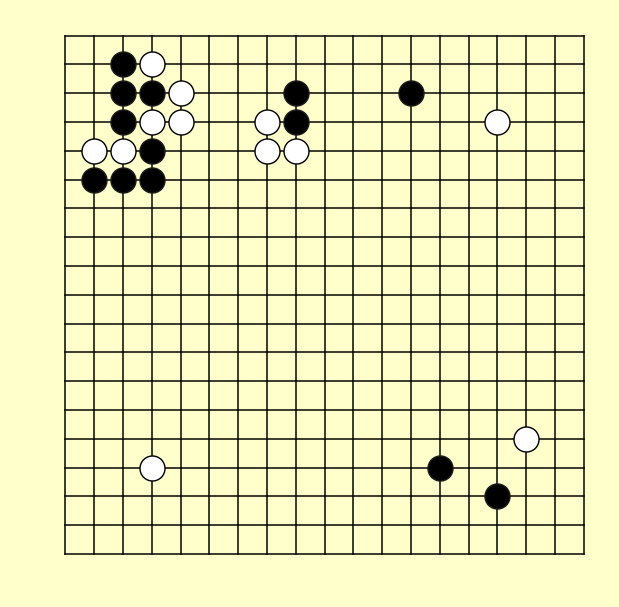

In [14]:
draw_board(np_board)

In [15]:
%%time

"""
 Parallel, without choice-with-dist

"""

# Number of boards
N = 50

np_boards = np.array([empty_board() for _ in range(N)])


# Depth for each board
for _ in range(12):
    preds = model.predict( np_boards )
    argmax_moves = np.argmax(preds[0][:,:361],axis=1)
    
    move_i = argmax_moves // 19
    move_j = argmax_moves % 19
    
    for b in range(N):
        np_boards[b,:,:,1] = np_boards[b,:,:,0].copy()
        while not place_stone(np_boards[b],move_i[b],move_j[b]):
            #preds[0][0][argmax_move] = 0
            preds[0][:,:361][b][argmax_moves[b]] = 0
            
            argmax_move = np.argmax( preds[0][0] )
            move_i[b] = argmax_move // 19
            move_j[b] = argmax_move % 19
        
        switch_player(np_boards[b])

CPU times: user 1min 3s, sys: 710 ms, total: 1min 4s
Wall time: 17.5 s


In [16]:
%%capture
!pip install pandas

In [17]:
import pandas as pd

In [34]:
%%time
"""
    Parallel, with weighted choice
"""
N = 250

np_boards = np.array([empty_board() for _ in range(N)])

first_move = True
first_moves = np.zeros(N)

for _ in range(5):
    preds = model.predict( np_boards )
    
    for b in range(N):
        argmax_move = np.argmax( preds[0][b] )
        move_weights = np.exp(preds[0][b][:361]) / np.sum(np.exp(preds[0][b][:361]))
        
        SPIKYNESS = 5
        spiked_weights = np.power(move_weights, SPIKYNESS) / np.sum( np.power(move_weights, SPIKYNESS) )
        
        draw_move = np.random.choice(361, 1,p=spiked_weights)[0]
        #print(draw_move)
        if first_move:
            first_moves[b] = draw_move
        
        move_i = draw_move // 19
        move_j = draw_move % 19
        
        np_boards[b,:,:,1] = np_boards[b,:,:,0].copy()
        
        while not place_stone(np_boards[b],move_i,move_j):
            
            spiked_weights[draw_move] = 0
            spiked_weights = spiked_weights / np.sum(spiked_weights)
            draw_move = np.random.choice(361, 1,p=spiked_weights)[0]
            
            move_i = draw_move // 19
            move_j = draw_move % 19
        
        switch_player(np_boards[b])
        
    first_move = False

move_stats = pd.DataFrame( preds[1],columns=["wr"] )
move_stats["move"] = first_moves

print(move_stats.groupby("move").agg({'wr':['mean','std','count']}).sort_values([("wr","mean")], ascending=False) )

             wr                
           mean       std count
move                           
73.0  -0.214685  0.008998    28
307.0 -0.217838  0.022642    23
287.0 -0.218759  0.021935    28
301.0 -0.219533  0.022200    29
53.0  -0.220241  0.012328    39
319.0 -0.222988  0.020885    30
59.0  -0.230526  0.019572    41
41.0  -0.235320  0.015360    32
CPU times: user 2min 11s, sys: 1.42 s, total: 2min 12s
Wall time: 35.1 s


In [35]:
def move_to_coord(move):
    move_i = move // 19
    move_j = move % 19
    
    print(move_i)
    print(move_j)

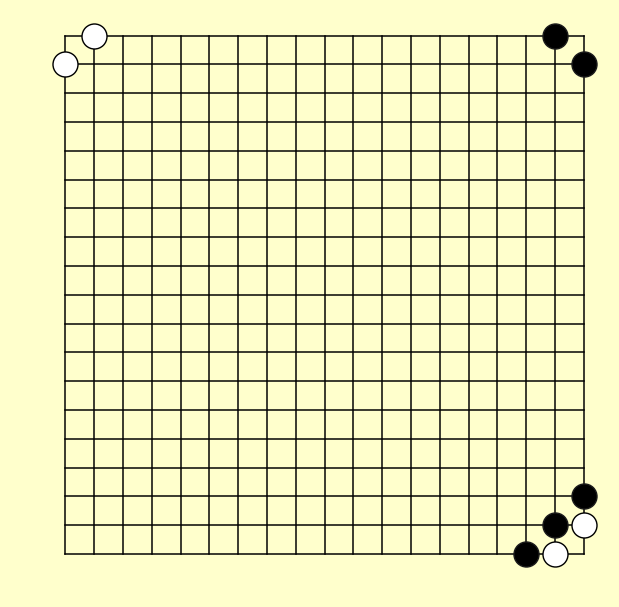

In [36]:
test_board = empty_board()

test_board[1,0,8] = 1
test_board[0,1,8] = 1

test_board[0,17,0] = 1
test_board[1,18,0] = 1

test_board[18,17,8] = 1
test_board[17,18,8] = 1

test_board[17,17,0] = 1
test_board[18,16,0] = 1
test_board[16,18,0] = 1

draw_board(test_board)

In [37]:
has_liberties(test_board,1,18)

True

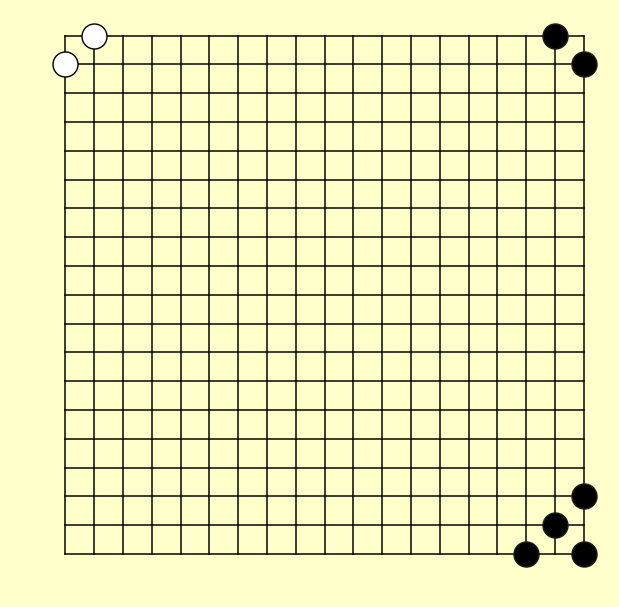

In [38]:
place_stone(test_board,18,18)
draw_board(test_board)